In [11]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from model.training.rollout_data import RolloutBuffer as Buffer
from task.gridworld import CnnWrapper, ThreadTheNeedleEnv
from utils.pytorch_utils import DEVICE
from model.agents.value_iteration import ValueIterationAgent
import seaborn as sns
from utils.pytorch_utils import (
    convert_float_to_8bit
)

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.2.1
device = mps


In [12]:
import pickle
with open('simulations/ppo_batched_data.pkl', 'rb') as f:
    ppo_batch_data = pickle.load(f)

with open('simulations/cnnvae_batched_data.pkl', 'rb') as f:
    cnnvae_batch_data = pickle.load(f)

with open('simulations/lookahead_batched_data_2024-06-09.pkl', 'rb') as f:
    lookahead_batched_data = pickle.load(f)

with open('simulations/discrete_ppo_batched_data_2024-09-05.pkl', 'rb') as f:
    discrete_ppo_batched_data = pickle.load(f)

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packag

<Axes: xlabel='num_timesteps', ylabel='average_reward'>

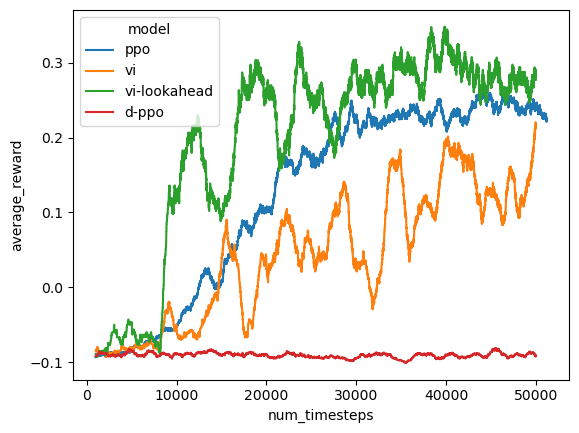

In [13]:
metric = 'average_reward'
metric_fn = lambda x: x.rolling(1000).mean()

reward_df = []
for ii, data in enumerate(ppo_batch_data):
    _rew = pd.DataFrame(data['rewards'])
    _rew['batch'] = ii
    _rew[metric] = metric_fn(_rew['rewards'])
    _rew['model'] = 'ppo'
    reward_df.append(_rew)

for ii, data in enumerate(cnnvae_batch_data):
    _rew = pd.DataFrame(data['rewards'])
    _rew['batch'] = ii
    _rew[metric] = metric_fn(_rew['rewards'])
    _rew['model'] = 'vi'
    reward_df.append(_rew)

for ii, data in enumerate(lookahead_batched_data):
    _rew = pd.DataFrame(data['rewards'])
    _rew['batch'] = ii
    _rew[metric] = metric_fn(_rew['rewards'])
    _rew['model'] = 'vi-lookahead'
    reward_df.append(_rew)

for ii, data in enumerate(discrete_ppo_batched_data):
    _rew = pd.DataFrame(data['rewards'])
    _rew['batch'] = ii
    _rew[metric] = metric_fn(_rew['rewards'])
    _rew['model'] = 'd-ppo'
    reward_df.append(_rew)

reward_df = pd.concat(reward_df)
sns.lineplot(data=reward_df.dropna(), x='num_timesteps', y=metric, hue='model', errorbar=None)


/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-pack

Text(0.5, 0.98, 'PPO Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

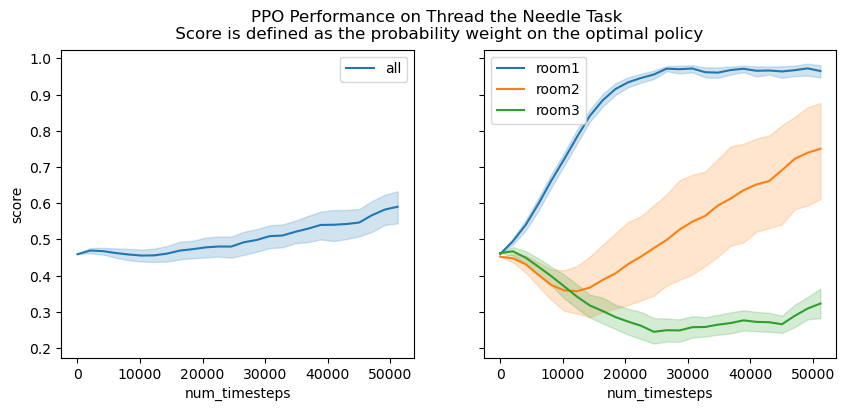

In [14]:
scores = []
for ii, batch in enumerate(ppo_batch_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores.append(scores_)
scores = pd.concat(scores)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.lineplot(data=scores, x='num_timesteps', y='score', label='all', ax=axes[0])

sns.lineplot(data=scores, x='num_timesteps', y='score_room1', label='room1', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room2', label='room2', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room3', label='room3', ax=axes[1])
plt.suptitle('PPO Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-pack

Text(0.5, 0.98, 'CNN VI Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

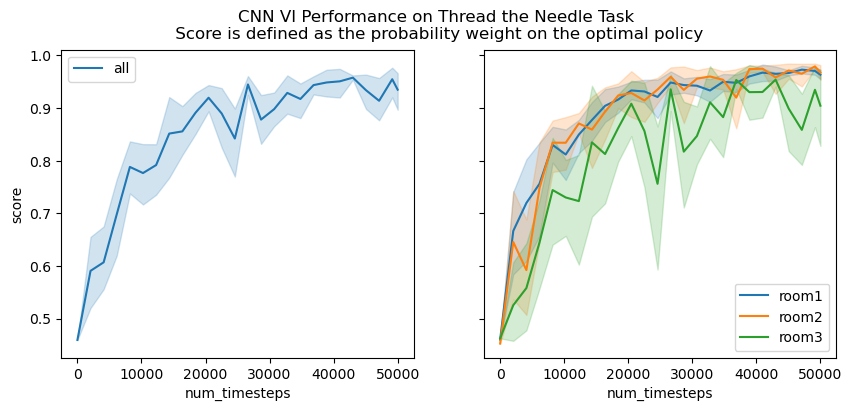

In [15]:
scores = []
for ii, batch in enumerate(cnnvae_batch_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores.append(scores_)
scores = pd.concat(scores)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.lineplot(data=scores, x='num_timesteps', y='score', label='all', ax=axes[0])

sns.lineplot(data=scores, x='num_timesteps', y='score_room1', label='room1', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room2', label='room2', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room3', label='room3', ax=axes[1])
plt.suptitle('CNN VI Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-pack

Text(0.5, 0.98, 'CNN VI Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

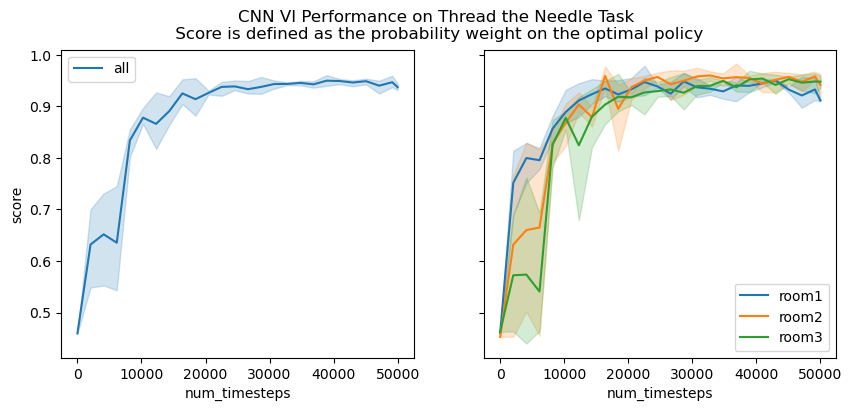

In [16]:
scores = []
for ii, batch in enumerate(lookahead_batched_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores.append(scores_)
scores = pd.concat(scores)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.lineplot(data=scores, x='num_timesteps', y='score', label='all', ax=axes[0])

sns.lineplot(data=scores, x='num_timesteps', y='score_room1', label='room1', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room2', label='room2', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room3', label='room3', ax=axes[1])
plt.suptitle('CNN VI Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packag

<Axes: xlabel='num_timesteps', ylabel='score'>

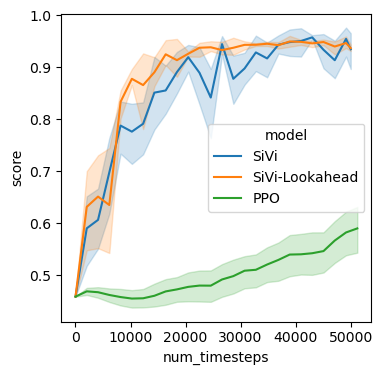

In [17]:
scores = []
for ii, batch in enumerate(cnnvae_batch_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores_['model'] = 'SiVi'
    scores.append(scores_)

for ii, batch in enumerate(lookahead_batched_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores_['model'] = 'SiVi-Lookahead'
    scores.append(scores_)

for ii, batch in enumerate(ppo_batch_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores_['model'] = 'PPO'
    scores.append(scores_)
scores = pd.concat(scores)

fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
sns.lineplot(data=scores, x='num_timesteps', y='score',  hue='model', ax=axes)

# sns.lineplot(data=scores, x='num_timesteps', y='score_room1', label='room1', ax=axes[1])
# sns.lineplot(data=scores, x='num_timesteps', y='score_room2', label='room2', ax=axes[1])
# sns.lineplot(data=scores, x='num_timesteps', y='score_room3', label='room3', ax=axes[1])
# plt.suptitle('CNN VI Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')